In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import pvlib
from pvlib.pvsystem import PVSystem, Array, FixedMount
from pvlib.location import Location
from pvlib.modelchain import ModelChain

In [2]:

# latitudes, longitude, name, altitude, timezone
coordinates = [(51.30,6.33, 'Kamp-Lintfort', 32,'Etc/GMT+2' ),
              (51.26,6.46, 'Duisburg', 34, 'Etc/GMT+2'),
              (51.27,6.38,'Moers', 32, 'Etc/GMT+2'),]

In [3]:
#get the module and inverter specifications from SAM

sandia_modules = pvlib.pvsystem.retrieve_sam('SandiaMod')
sapm_inverters = pvlib.pvsystem.retrieve_sam('cecinverter')
module = sandia_modules['Canadian_Solar_CS5P_220M___2009_']
inverter = sapm_inverters['ABB__MICRO_0_25_I_OUTD_US_208__208V_']
temperature_model_parameters = pvlib.temperature.TEMPERATURE_MODEL_PARAMETERS['sapm']['open_rack_glass_glass']


In [4]:
##retrieving meteorological data for the simulation, using iotools

tmys = []

for location in coordinates:
    latitude, longitude, name, altitude, timezone = location 
    weather = pvlib.iotools.get_pvgis_tmy(latitude, longitude, map_variables = True)[0]
    weather.index.name = "utc_time"
    tmys.append(weather)

In [5]:
energies = {}

In [6]:
for location, weather in zip(coordinates, tmys):
    latitude, longitude, name, altitude, timezone = location
    location = Location(
    latitude,
    longitude,
    name = name, altitude = altitude,
    tz = timezone,
    )
    mount = FixedMount(surface_tilt=latitude, surface_azimuth=180)
    array = Array(
    mount = mount,
    module_parameters = module,
    temperature_model_parameters = temperature_model_parameters,
    )
    
    system = PVSystem(arrays=[array], inverter_parameters=inverter)
    mc = ModelChain(system, location)
    mc.run_model(weather)
    annual_energy = mc.results.ac.sum()
    energies[name] = annual_energy
    

In [7]:
energies = pd.Series(energies)

In [8]:
print(energies)

Kamp-Lintfort    258457.366571
Duisburg         225415.025654
Moers            233313.595637
dtype: float64


Text(0, 0.5, 'Yearly energy yield (W hr)')

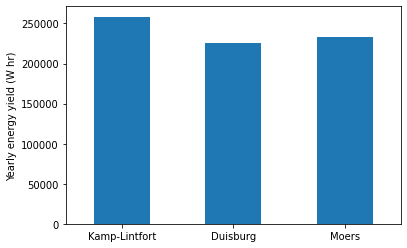

In [9]:
energies.plot(kind='bar', rot=0)
plt.ylabel('Yearly energy yield (W hr)')